Policy Gradient with Batches 

In [26]:
import torch
import torch.nn as nn
import gymnasium as gym 
import numpy as np 

import torch.optim as optim

from sklearn.preprocessing import StandardScaler

# distribution functions 
from torch.distributions import Categorical 

import sys
sys.path.append('../')


### Initialize the Policy 

In [27]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()

        self.fnn = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, action_dim),
            nn.Softmax()
        )

        # storing the log probability distribution
        self.log_probabilities = []
        
        # storing the rewards for each step
        self.rewards = []

    def reset(self):
        """ Internal reset """
        self.log_probabilities = []
        self.rewards = []

    def forward(self, state):
        action_logits = self.fnn(state)

        return action_logits
    
    def tensor(self, obs):
        return torch.FloatTensor(obs)
    
    @torch.no_grad()
    def predict(self, obs):
        obs_tensor = self.tensor(obs)
        probs = self.fnn(obs_tensor)
        action = torch.argmax(probs).item()
        return action

    def generate_q_table(self, usable_ace=False, starting_pos=12):
        """Generate a tabular Q-value dict for plotting."""
        self.q_values = {}
        for player_sum in range(starting_pos, 22):
            for dealer_card in range(1, 11):
                state = (player_sum, dealer_card, usable_ace)
                state_tensor = self.tensor(state)
                q_vals = self.predict(state_tensor)
                self.q_values[state] = q_vals

In [ ]:
env = gym.make("Blackjack-v1")

# policy initializations 
policy = Policy(3, 2)

optimizer = optim.Adam(policy.parameters(),lr=0.0005)

losses = []
best_reward = -np.inf 
avg_reward= 0

gamma = 0.999
break_counter = 0
epoches = 50_000
episode_rewards = []  
avg_rewards = []
batch_sizes = 32

hit_probability = []
stick_probability = []

for e in range(epoches):

    batch_log_probs = []
    batch_rewards = []
    batch_discounted_rewards = []
    batch_episode_rewards = []
    _h = []
    _s = []


    for b in range(batch_sizes):

        # Run N episodes -> collect all rewards + log_probs 
        obs = env.reset()[0]
        termination = False
        ep_rewards = []
        ep_log_probs = []
        termination = False 

        while not termination:

            # sample a action from the probability distribution 
            state_tensors = torch.FloatTensor(obs)
            action_tensors = policy(state_tensors)

            # logging hit or stick 
            h, s = action_tensors[0].item(), action_tensors[1].item() 
            _h.append(h)
            _s.append(s)

            # Create a distribution based on the probability from the softmax layer
            distribution = Categorical(action_tensors)

            # stohastic sampling 
            action = distribution.sample()

            # log * π(A|S)
            log_probabilities = distribution.log_prob(action)

            # rewarding 

            obs, reward, termination, truncation, info = env.step(action.item())
            # reward *= 10
            
            if b < batch_sizes/4 and action ==1:
                reward *= 5
            
            # record the rewards 
            ep_rewards.append(reward)

            # storing the log probabilities
            ep_log_probs.append(log_probabilities)

        # print('Finished one episode....computing rewards and gradients now...')

        """
        paramter updates = parameter updates + stepping sizes * sum(log_probabilities * Gt)

        1st step: calculate the Gt at each iteration 
        Gt = Imeddiate reward + future reward * gamma
        """

        # still doing this for 1 episode 
        discounted_rewards = []
        R = 0

        for r in reversed(ep_rewards):
            R = r + gamma * R
            discounted_rewards.append(R)

        discounted_rewards = list(reversed(discounted_rewards))
        discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9)
        discounted_rewards = torch.tensor(discounted_rewards)

        # append this metadata of this episode to the batch list 
        batch_log_probs.extend(ep_log_probs)
        batch_discounted_rewards.extend(discounted_rewards)
        batch_episode_rewards.append(sum(ep_rewards))

        # policy.reset()

    # now compute batch loss 
    batch_log_probs = torch.stack(batch_log_probs)
    batch_discounted_rewards = torch.tensor(batch_discounted_rewards)

    # entropy control 
    entropy = distribution.entropy()

    policy_loss = -batch_log_probs * batch_discounted_rewards
    policy_loss = policy_loss.sum() - 0.03 * entropy.sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    # logging 
    avg_batch_reward = np.mean(batch_episode_rewards)
    episode_rewards.append(avg_batch_reward)

    hit_probability.append(np.mean(_h))
    stick_probability.append(np.mean(_s))

    if e > 100:
        avg_reward = np.mean(episode_rewards[-100:])
        avg_rewards.append(avg_reward)
        print(f"Epoch {e} | Avg Reward (last 100): {avg_reward:.2f}")

    if avg_reward > best_reward and e > 100:
        best_reward = avg_reward
        torch.save(policy.state_dict(), '../checkpoints/policy_gradient_batch.pth')
        break_counter = 0
    else:
        break_counter += 1

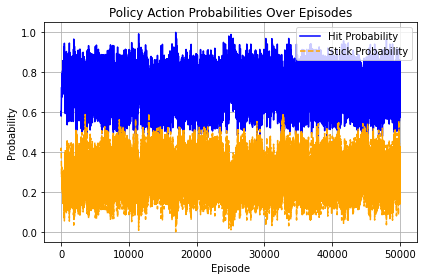

In [34]:
import matplotlib.pyplot as plt

# Example data — replace with your real lists
episodes = list(range(len(hit_probability)))

# Plot both
plt.plot(episodes, hit_probability, label='Hit Probability', color='blue', linestyle='-')
plt.plot(episodes, stick_probability, label='Stick Probability', color='orange', linestyle='--')


# Add labels and legend
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.title('Policy Action Probabilities Over Episodes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


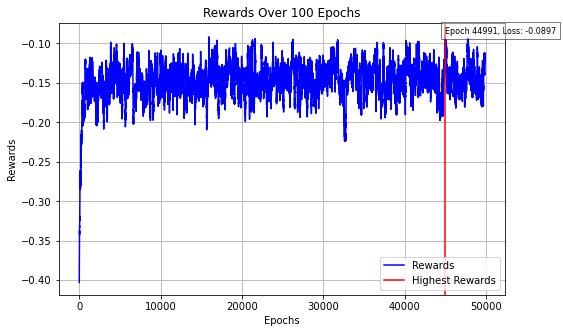

In [35]:
import matplotlib.pyplot as plt

# Ensure both lists have the same length
epochs = list(range(1, len(avg_rewards) + 1))

# Find min loss points
min_train_index = avg_rewards.index(max(avg_rewards))

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(avg_rewards, label="Rewards", linestyle='-', color='blue')

# Add vertical lines at minimum loss points
plt.axvline(x=min_train_index, color='red', linestyle='-', label='Highest Rewards')

# Add text labels at min loss points
plt.text(min_train_index, max(avg_rewards), 
         f'Epoch {min_train_index}, Loss: {max(avg_rewards):.4f}', 
         ha='left', va='bottom', fontsize=8, 
         bbox={'facecolor': 'white', 'alpha': 0.5})

# Labels, legend, and grid
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.title("Rewards Over 100 Epochs")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [41]:
from modules.utils import * 

policy.load_state_dict(torch.load('../checkpoints/policy_gradient_batch.pth'))

<All keys matched successfully>

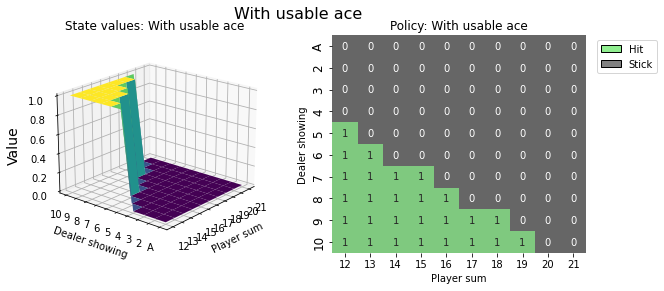

In [42]:
from collections import defaultdict
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

def create_grids(agent, usable_ace=False, starting_pos=12):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = action_values
        policy[obs] = action_values

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(starting_pos, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid
    

def create_plots(value_grid, policy_grid, title: str, starting_pos=12):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(starting_pos, 22), range(starting_pos, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(starting_pos, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

policy.generate_q_table(usable_ace=True,starting_pos=12)
value_grid, policy_grid = create_grids(policy, usable_ace=True, starting_pos=12)
fig = create_plots(value_grid, policy_grid, title="With usable ace",starting_pos=12)
plt.show()

np.save('../checkpoints/Batch_Policy_Gradient.npy', policy_grid)


In [43]:
basic_strategy_grid = np.array([
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],  # Dealer shows Ace
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 4
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 5
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 6
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 7
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 8
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 9
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Dealer shows 10
])

coverage = policy_grid == basic_strategy_grid
coverage_pcnt = np.sum(coverage) / coverage.size * 100
print(f"Policy matches basic strategy on {np.sum(coverage)}/{coverage.size} cells")
print(f"Coverage: {coverage_pcnt:.2f}%")

Policy matches basic strategy on 68/100 cells
Coverage: 68.00%


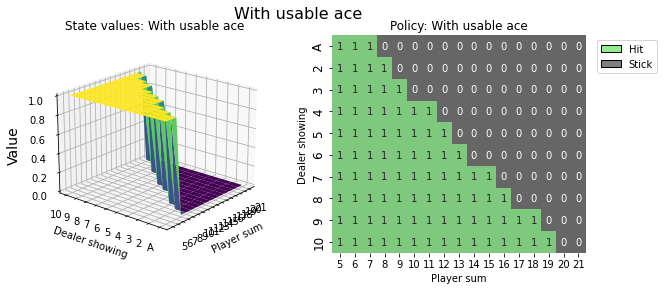

In [44]:
starting_pos = 5
policy.generate_q_table(usable_ace=True,starting_pos=starting_pos)
value_grid, policy_grid = create_grids(policy, usable_ace=True, starting_pos=starting_pos)
fig = create_plots(value_grid, policy_grid, title="With usable ace",starting_pos=starting_pos)
plt.show()

In [40]:
import json
import numpy as np
from collections import defaultdict
import torch

def generate_policy(policy_net, save_path):
    policy_data = defaultdict(lambda: np.zeros(2))

    for player_sum in range(1, 22):           # 1 to 21
        for dealer_card in range(1, 11):      # 1 (Ace) to 10
            for usable_ace in [0, 1]:
                state = (player_sum, dealer_card, usable_ace)

                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    action_probs = policy_net(state_tensor).squeeze().numpy()

                policy_data[state] = np.argmax(action_probs)

    # Save as JSON
    serializable = {str(k): v.tolist() for k, v in policy_data.items()}
    with open(save_path, "w") as f:
        json.dump(serializable, f, indent=2)

    print(f"Policy saved to {save_path}")
    return policy_data


policy_data = generate_policy(policy, "../policies/Batch_Policy_Gradient.json")

Policy saved to ../policies/Batch_Policy_Gradient.json
